# Graphs for paper for combinations

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [4]:
import sys
sys.path.append('../')

In [5]:
import neptune

In [6]:
## download from neptune
START_ID, END_ID = 558, 591
SKIP_IDS = []
RUN_IDS = [f"TSDRLOC-{i}" for i in range(START_ID, END_ID + 1) if i not in SKIP_IDS]

In [9]:
RUNS = []
for run_id in RUN_IDS:
    run = neptune.init_run(
        project="yuuk1/tsdr-localization",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
    )
    if run["sys/trashed"].fetch() == True:
        run.stop()
        continue
    struct = run.get_structure()
    RUNS.append(struct)
    run.stop()

https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-558
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-558/metadata
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-559
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-559/metadata
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-560
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-560/metadata
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-561
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!

In [10]:
len(RUNS)

32

In [187]:
def convert_to_dataset_name(target_app: str, middleware: bool) -> str:
    match target_app, middleware:
        case "sock-shop", False:
            return "A-common"
        case "sock-shop", True:
            return "A-middleware"
        case "train-ticket", False:
            return "B-common"
        case "train-ticket", True:
            return "B-middleware"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}")

In [188]:
items = []
for run in RUNS:
    target_app = run["dataset"]["target_app"].fetch()
    middleware = run["dataset"]["metric_types"]["middlewares"].fetch()

    reduction: str
    tsdr_params = run["parameters"]["tsdr"]
    enable_uni: bool = tsdr_params["enable_unireducer"].fetch()
    enable_multi: bool = tsdr_params["enable_multireducer"].fetch()
    if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
        uni_method = uni_method.fetch()
    if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
        multi_method = multi_method.fetch()
    if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
        multi_dist_type = multi_dist_type.fetch()
    
    match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
        case (False, False, _, _, _):
            reduction = "None"
        case (False, True, _, "changepoint-kde", _):
            reduction = "TSifter"
        case (True, False, "zscore_nsigma", _, _):
            reduction = "NSigma"
        case (True, False, "birch_model", _, _):
            reduction = "Birch"
        case (True, False, "two_samp_test", _, _):
            reduction = "K-S test"
        case (True, False, "fluxinfer", _, _):
            reduction = "FluxInfer-AD"
        case (False, True, _, "hdbscan", "sbd"):
            reduction = "HDBSCAN-SBD"
        case (False, True, _, "hdbscan", "pearsonr"):
            reduction = "HDBSCAN-PEARSON"
        case (_, _, _, _, _):
            assert False, f"Unknown reduction method: {tsdr_params}"

    # 1. e-Diagnosis
    # 2. RCD
    # 3. CausalRCA+PageRank
    # 4. PC+RW-2
    # 5. GES+RW-2
    # 6. LiNGAM+RW-2
    # 7. PC+PageRank
    # 8. GES+PageRank
    # 9. LiNGAM+PageRank
    # 10. PC+HT
    # 11. GES+HT
    # 12. LiNGAM+HT
    localization: str
    loc_params = run["parameters"]
    if pyrca_method := loc_params.get("method", ""):
        pyrca_method = pyrca_method.fetch()
    if walk_method := loc_params.get("walk_method", ""):
        walk_method = walk_method.fetch()

    if pyrca_method == "epsilon_diagnosis":
        localization = "e-Diagnosis"
    elif loc_params.get("use_rcd", False):
        localization = "RCD"
    elif loc_params.get("use_causalrca", False):
        localization = "CausalRCA"
    elif pyrca_method == "pc" and walk_method == "rw-2":
        localization = "PC+RW-2"
    elif pyrca_method == "fges" and walk_method == "rw-2":
        localization = "GES+RW-2"
    elif pyrca_method == "lingam" and walk_method == "rw-2":
        localization = "LiNGAM+RW-2"
    elif pyrca_method == "pc" and walk_method == "pagerank":
        localization = "PC+PageRank"
    elif pyrca_method == "fges" and walk_method == "pagerank":
        localization = "GES+PageRank"
    elif pyrca_method == "lingam" and walk_method == "pagerank":
        localization = "LiNGAM+PageRank"
    elif pyrca_method == "pc" and walk_method == "ht":
        localization = "PC+HT"
    elif pyrca_method == "fges" and walk_method == "ht":
        localization = "GES+HT"
    elif pyrca_method == "lingam" and walk_method == "ht":
        localization = "LiNGAM+HT"
    else:
        assert False, f"Unknown localization method: {loc_params}"

    ac2 = run["scores"]["metric"]["AC_2"].fetch()
    ac5 = run["scores"]["metric"]["AC_5"].fetch()
    avg5 = run["scores"]["metric"]["AVG_5"].fetch()
    elapsed_time = run["elapsed_time"]["mean"]["elapsed_time"].fetch()
    items.append({"dataset": convert_to_dataset_name(target_app, middleware),
                  "reduction_method": reduction, "localization_method": localization,
                  "ac@2": ac2, "ac@5": ac5, "avg@5": avg5, "elapsed_time": elapsed_time})

In [189]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    loc_tsdr_df = pd.DataFrame(items)
    display(loc_tsdr_df.set_index(["dataset", "reduction_method", "localization_method"]).sort_index())

ac@2      ac@5  \
dataset      reduction_method localization_method                       
A-common     Birch            RCD                  0.488889  0.622222   
                              e-Diagnosis          0.000000  0.000000   
             FluxInfer-AD     RCD                  0.503704  0.629630   
                              e-Diagnosis          0.000000  0.014815   
             HDBSCAN-PEARSON  RCD                  0.496296  0.577778   
                              e-Diagnosis          0.044444  0.237037   
             HDBSCAN-SBD      RCD                  0.555556  0.622222   
                              e-Diagnosis          0.022222  0.177778   
             K-S test         RCD                  0.496296  0.607407   
                              e-Diagnosis          0.000000  0.014815   
             NSigma           RCD                  0.526718  0.656489   
                              e-Diagnosis          0.000000  0.000000   
             None             RCD                  0.511111  0.614815   
                              e-Diagnosis          0.000000  0.007407   
             TSifter          RCD                  0.562963  0.644444   
                              e-Diagnosis          0.133333  0.340741   
A-middleware Birch            RCD                  0.240602  0.375940   
                              e-Diagnosis          0.000000  0.000000   
             FluxInfer-AD     RCD                  0.229630  0.362963   
                              e-Diagnosis          0.000000  0.000000   
             HDBSCAN-PEARSON  RCD                  0.259259  0.370370   
                              e-Diagnosis          0.000000  0.000000   
             HDBSCAN-SBD      RCD                  0.222222  0.377778   
                              e-Diagnosis          0.000000  0.000000   
             K-S test         RCD                  0.222222  0.385185   
                              e-Diagnosis          0.000000  0.000000   
             NSigma           RCD                  0.251908  0.374046   
                              e-Diagnosis          0.000000  0.000000   
             None             RCD                  0.259259  0.414815   
                              e-Diagnosis          0.000000  0.000000   
             TSifter          RCD                  0.229630  0.362963   
                              e-Diagnosis          0.029630  0.081481   

                                                      avg@5  elapsed_time  
dataset      reduction_method localization_method                          
A-common     Birch            RCD                  0.533333     82.270278  
                              e-Diagnosis          0.000000      5.955241  
             FluxInfer-AD     RCD                  0.534815     84.600981  
                              e-Diagnosis          0.002963      6.240240  
             HDBSCAN-PEARSON  RCD                  0.518519     27.840772  
                              e-Diagnosis          0.103704      2.258535  
             HDBSCAN-SBD      RCD                  0.564444     30.158907  
                              e-Diagnosis          0.072593      2.309218  
             K-S test         RCD                  0.520000     85.243344  
                              e-Diagnosis          0.002963      6.223828  
             NSigma           RCD                  0.557252     75.362580  
                              e-Diagnosis          0.000000      5.956818  
             None             RCD                  0.534815    102.683118  
                              e-Diagnosis          0.001481      7.239587  
             TSifter          RCD                  0.586667     38.696724  
                              e-Diagnosis          0.214815      3.894048  
A-middleware Birch            RCD                  0.275188    542.001034  
                              e-Diagnosis          0.000000     40.748816  
             FluxInfer-AD     RCD                  0

/tmp/ipykernel_4173602/507188560.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)


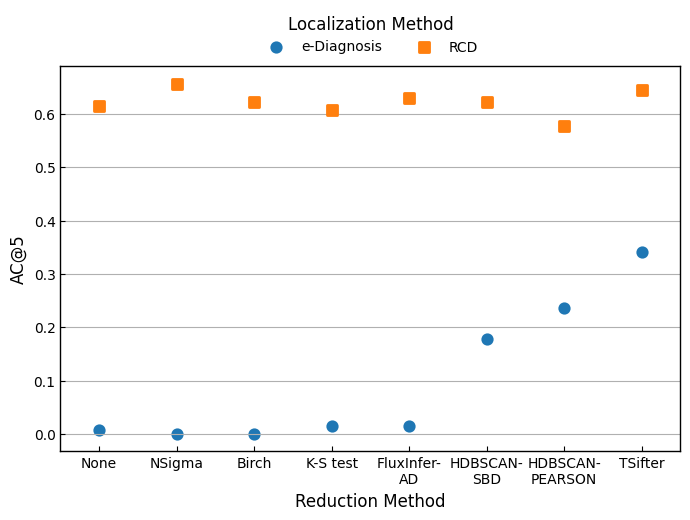

In [131]:
import seaborn as sns

def wrap(label: str):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBSCAN-\nSBD"
        case "HDBSCAN-PEARSON":
            return "HDBSCAN-\nPEARSON"
    return label

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.pointplot(data=loc_tsdr_df[loc_tsdr_df["middleware"] == False], x="reduction_method", y="ac@5", hue="localization_method", markers=["o", "s"], linestyles=["", ""], order=["None", "NSigma", "Birch", "K-S test", "FluxInfer-AD", "HDBSCAN-SBD", "HDBSCAN-PEARSON", "TSifter"], ax=ax)

ax.set_xlabel("Reduction Method", fontsize=12)
ax.set_ylabel("AC@5", fontsize=12)
ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.legend(title="Localization Method")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title="Localization Method", frameon=False, fontsize=10, title_fontsize=12
)

## Load tsdr

In [212]:
TSDR_START_ID, TSDR_END_ID = 457, 472
TSDR_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_START_ID, TSDR_END_ID + 1)]

In [213]:
TSDR_RUNS = []
for run_id in TSDR_RUN_IDS:
    run = neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
    )
    if run["sys/trashed"].fetch() == True:
        run.stop()
        continue
    struct = run.get_structure()
    TSDR_RUNS.append(struct)
    run.stop()

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-457
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-457
Shutting down background jobs, please wait a moment...
Shutting down background jobs, please wait a moment...
Done!
Done!
All 0 operations synced, thanks for waiting!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-457/metadata
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-457/metadata
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-458
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-458
Shutting down background jobs, please wait a moment...
Shutting down background jobs, please wait a moment...
Done!
Done!
All 0 operations synced, thanks for waiting!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-458/metadata
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-458/metadata
https://app.nept

In [214]:
tsdr_items = []
for run in TSDR_RUNS:
    target_app = run["dataset"]["target_app"].fetch()
    middleware = run["dataset"]["metric_types"]["middlewares"].fetch()

    reduction: str
    tsdr_params = run["parameters"]
    enable_uni: bool = tsdr_params["enable_unireducer"].fetch()
    enable_multi: bool = tsdr_params["enable_multireducer"].fetch()
    if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
        uni_method = uni_method.fetch()
    if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
        multi_method = multi_method.fetch()
    if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
        multi_dist_type = multi_dist_type.fetch()
    
    match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
        case (False, False, _, _, _):
            reduction = "None"
        case (False, True, _, "changepoint-kde", _):
            reduction = "TSifter"
        case (True, False, "zscore_nsigma", _, _):
            reduction = "NSigma"
        case (True, False, "birch_model", _, _):
            reduction = "Birch"
        case (True, False, "two_samp_test", _, _):
            reduction = "K-S test"
        case (True, False, "fluxinfer", _, _):
            reduction = "FluxInfer-AD"
        case (False, True, _, "hdbscan", "sbd"):
            reduction = "HDBSCAN-SBD"
        case (False, True, _, "hdbscan", "pearsonr"):
            reduction = "HDBSCAN-PEARSON"
        case (_, _, _, _, _):
            assert False, f"Unknown reduction method: {tsdr_params}"

    frr = run["scores"]["reduction_rate_mean"].fetch()
    rfr = run["scores"]["cause_metrics"]["recall_mandatory_mean"].fetch()
    # rfp = run["scores"]["cause_metrics"]["proportion_mandatory_mean"].fetch()
    rfp = 0.0
    elapsed_time = run["scores"]["elapsed_time_min"].fetch()
    tsdr_items.append({"dataset": convert_to_dataset_name(target_app, middleware),
                  "reduction_method": reduction,
                  "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time})

In [217]:
reduction_methods = ["None", "TSifter", "NSigma", "Birch", "K-S test", "FluxInfer-AD", "HDBSCAN-SBD", "HDBSCAN-PEARSON"]
metrics = ["FRR", "RFR", "RFP", "elapsed_time"]

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product(
        [["A-common", "A-middleware"], reduction_methods], names=['dataset', 'reduction_method'])
    multi_level_cols = pd.MultiIndex.from_product(
        [["A-common", "A-middleware"], metrics], names=['dataset', 'metric'])
    tsdr_df = pd.DataFrame(tsdr_items, index=["reduction_method"], columns=multi_level_cols)
    # tsdr_df.drop(["target_app", "middleware"], axis=1, inplace=True)
    # tsdr_df.set_index(["reduction_method"], inplace=True)
    # tsdr_df.columns = multi_level_cols
    # display_tsdr_df = tsdr_df.set_index(["target_app", "middleware", "reduction_method"]).sort_index()
    display(tsdr_df)

dataset A-common                      A-middleware                     
metric       FRR RFR RFP elapsed_time          FRR RFR RFP elapsed_time
0            NaN NaN NaN          NaN          NaN NaN NaN          NaN
1            NaN NaN NaN          NaN          NaN NaN NaN          NaN
2            NaN NaN NaN          NaN          NaN NaN NaN          NaN
3            NaN NaN NaN          NaN          NaN NaN NaN          NaN
4            NaN NaN NaN          NaN          NaN NaN NaN          NaN
5            NaN NaN NaN          NaN          NaN NaN NaN          NaN
6            NaN NaN NaN          NaN          NaN NaN NaN          NaN
7            NaN NaN NaN          NaN          NaN NaN NaN          NaN
8            NaN NaN NaN          NaN          NaN NaN NaN          NaN
9            NaN NaN NaN          NaN          NaN NaN NaN          NaN
10           NaN NaN NaN          NaN          NaN NaN NaN          NaN
11           NaN NaN NaN          NaN          NaN NaN NaN          NaN
12           NaN NaN NaN          NaN          NaN NaN NaN          NaN
13           NaN NaN NaN          NaN          NaN NaN NaN          NaN
14           NaN NaN NaN          NaN          NaN NaN NaN          NaN
15           NaN NaN NaN          NaN          NaN NaN NaN          NaN

In [ ]:
tsdr_s = display_tsdr_df.style
tsdr_s.clear()
tsdr_s.format({
    ("Numeric", "FRR"): '{:.2f}',
    ("Numeric", "RFR"): '{:.2f}',
    ("Numeric", "RFP"): '{:.2f}',
    ("Numeric", "elapsed_time"): '{:.2f}',
})
print(tsdr_s.to_latex())

\begin{tabular}{lllrrrr}
 &  &  & FRR & RFR & RFP & elapsed_time \\
target_app & middleware & reduction_method &  &  &  &  \\
\multirow[c]{14}{*}{sock-shop} & \multirow[c]{7}{*}{False} & Birch & 0.185164 & 0.974074 & 0.000000 & 0.369600 \\
 &  & FluxInfer-AD & 0.128849 & 0.966667 & 0.000000 & 0.611700 \\
 &  & HDBSCAN-PEARSON & 0.691715 & 0.252963 & 0.000000 & 0.905800 \\
 &  & HDBSCAN-SBD & 0.685723 & 0.252963 & 0.000000 & 0.702600 \\
 &  & K-S test & 0.128849 & 0.966667 & 0.000000 & 0.600300 \\
 &  & NSigma & 0.192666 & 0.975926 & 0.000000 & 0.580100 \\
 &  & TSifter & 0.462100 & 0.858642 & 0.000000 & 0.898900 \\
 & \multirow[c]{7}{*}{True} & Birch & 0.250693 & 0.950669 & 0.000000 & 0.757100 \\
 &  & FluxInfer-AD & 0.119126 & 0.966663 & 0.000000 & 1.042300 \\
 &  & HDBSCAN-PEARSON & 0.835740 & 0.179972 & 0.000000 & 61.393100 \\
 &  & HDBSCAN-SBD & 0.842580 & 0.182799 & 0.000000 & 4.939500 \\
 &  & K-S test & 0.119126 & 0.966663 & 0.000000 & 1.016700 \\
 &  & NSigma & 0.333519 & 0.954

## Join tsdr and localization

In [ ]:
joined_df = loc_tsdr_df.set_index(["target_app", "middleware", "localization_method"]).join(tsdr_df.set_index(["target_app", "middleware", "reduction_method"]), how="inner", on=['target_app', 'middleware', 'reduction_method'], lsuffix='_loc', rsuffix='_tsdr')
joined_df["elapsed_time_sum"] = joined_df["elapsed_time_loc"] + joined_df["elapsed_time_tsdr"]
joined_df.reset_index().set_index(['target_app', 'middleware', 'localization_method', 'reduction_method']).sort_index()

ac@2  \
target_app middleware localization_method reduction_method             
sock-shop  False      RCD                 Birch             0.488889   
                                          FluxInfer-AD      0.503704   
                                          HDBSCAN-PEARSON   0.496296   
                                          HDBSCAN-SBD       0.555556   
                                          K-S test          0.496296   
                                          NSigma            0.526718   
                                          TSifter           0.562963   
                      e-Diagnosis         Birch             0.000000   
                                          FluxInfer-AD      0.000000   
                                          HDBSCAN-PEARSON   0.044444   
                                          HDBSCAN-SBD       0.022222   
                                          K-S test          0.000000   
                                          NSigma            0.000000   
                                          TSifter           0.133333   
           True       RCD                 Birch             0.240602   
                                          FluxInfer-AD      0.229630   
                                          HDBSCAN-PEARSON   0.259259   
                                          HDBSCAN-SBD       0.222222   
                                          K-S test          0.222222   
                                          NSigma            0.251908   
                                          TSifter           0.229630   
                      e-Diagnosis         Birch             0.000000   
                                          FluxInfer-AD      0.000000   
                                          HDBSCAN-PEARSON   0.000000   
                                          HDBSCAN-SBD       0.000000   
                                          K-S test          0.000000   
                                          NSigma            0.000000   
                                          TSifter           0.029630   

                                                                ac@5  \
target_app middleware localization_method reduction_method             
sock-shop  False      RCD                 Birch             0.622222   
                                          FluxInfer-AD      0.629630   
                                          HDBSCAN-PEARSON   0.577778   
                                          HDBSCAN-SBD       0.622222   
                                          K-S test          0.607407   
                                          NSigma            0.656489   
                                          TSifter           0.644444   
                      e-Diagnosis         Birch             0.000000   
                                          FluxInfer-AD      0.014815   
                                          HDBSCAN-PEARSON   0.237037   
                                          HDBSCAN-SBD       0.177778   
                                          K-S test          0.014815   
                                          NSigma            0.000000   
                                          TSifter           0.340741   
           True       RCD                 Birch             0.375940   
                                          FluxInfer-AD      0.362963   
                                          HDBSCAN-PEARSON   0.370370   
                                          HDBSCAN-SBD       0.377778   
                                          K-S test          0.385185   
                                          NSigma            0.374046   
                                          TSifter           0.362963   
                      e-Diagnosis         Birch             0.000000   
                                          FluxInfer-AD      0.000000   
                                          HDBSCAN-PEARSON   0.000000   
                               